In [3]:
import numpy as np, pandas as pd
from scipy.stats import norm
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import seaborn as sns








In [4]:
df= pd.read_parquet('data/wines_with_weather.parquet')
df.head()

,Winery,Wine,vintage,vintage_rating,vintage_rating_count,wine_rating_count,wine_rating,region,price,cepages,...,TX_summer,temp_amp_summer,hot_days,rainy_days_summer,rain_June,rain_SepOct,frost_days_Apr,avg_TM_Apr,year,dist_km
0,Château de Lavagnac,Bordeaux 2015,2015,3.6,76,766,3.5,bordeaux,4.1,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,2015.0,5.314533
1,Château de Callac,Graves Rouge 2011,2011,3.6,221,3008,3.7,graves,4.5,cabernet-sauvignon,...,26.356452,11.301613,2.0,5.0,55.5,94.5,0.0,15.750000,2011.0,8.487753
2,Château Gravelier,Bordeaux Rouge 2022,2022,3.4,621,621,3.4,bordeaux,4.9,cabernet-sauvignon,...,32.291935,13.583871,17.0,1.0,110.8,82.4,0.0,13.300000,2022.0,1.518107
3,Château de Brandey,Bordeaux Rouge 2015,2015,3.6,333,1705,3.4,bordeaux,4.9,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,2015.0,5.314533
4,Les Hauts de Palette,Château Haut-Mondain Bordeaux Rouge 2016,2016,3.4,258,1919,3.6,bordeaux,4.9,cabernet-sauvignon,...,28.667742,12.424194,8.0,0.0,74.5,81.5,0.0,11.876667,2016.0,5.314533


In [5]:
#save the dataframe to a csv file
df.to_csv('data/wines_with_weather.csv', index=False)

In [ ]:
df = pd.read_csv('data/wines_with_coord.csv')
df = df.dropna(subset=['latitude', 'longitude','cepages'])

In [12]:
z = norm.ppf(0.95)          # 95 % one-sided z
eps = 0.7                   # value elasticity

# 1. Wilson lower-bound quality
p_star = df['wine_rating'] / 5
n      = df['wine_rating_count']
wilson = (
    p_star + z**2/(2*n) - z*np.sqrt((p_star*(1-p_star))/n + z**2/(4*n**2))
) / (1 + z**2/n)
df['quality'] = wilson

# 2. Value penalty
df['value_penalty'] = (1 + np.log1p(df['price'])).pow(eps)
df['ivs_raw'] = df['quality'] / df['value_penalty']

# 3. Build 25 km neighbourhood means (≈0.225° lat)
R = 6371  # Earth radius km
coords = np.radians(df[['latitude', 'longitude']])
tree = BallTree(coords, metric='haversine')
idxs = tree.query_radius(coords, r=25/R)
df['neigh_mean'] = [df.iloc[ids]['ivs_raw'].mean() for ids in idxs]
df['ivs_local'] = df['ivs_raw'] / df['neigh_mean']

# 4. 0-1 scaling
iv = df['ivs_local']
df['IVS'] = (iv - iv.min()) / (iv.max() - iv.min())

In [6]:
df.head()

,Winery,Wine,vintage,vintage_rating,vintage_rating_count,wine_rating_count,wine_rating,region,price,cepages,latitude,longitude,quality,value_penalty,ivs_raw,neigh_mean,ivs_local,IVS
0,Château de Lavagnac,Bordeaux 2015,2015,3.6,76,766,3.5,bordeaux,4.1,cabernet-sauvignon,44.83779,-0.57918,0.672100,1.967348,0.341628,0.263866,1.294703,0.908908
1,Château de Callac,Graves Rouge 2011,2011,3.6,221,3008,3.7,graves,4.5,cabernet-sauvignon,44.60000,-0.40000,0.726633,2.006729,0.362098,0.265058,1.366108,1.000000
2,Château Gravelier,Bordeaux Rouge 2022,2022,3.4,621,621,3.4,bordeaux,4.9,cabernet-sauvignon,44.83779,-0.57918,0.648486,2.043049,0.317411,0.263866,1.202926,0.791829
3,Château de Brandey,Bordeaux Rouge 2015,2015,3.6,333,1705,3.4,bordeaux,4.9,cabernet-sauvignon,44.83779,-0.57918,0.661145,2.043049,0.323607,0.263866,1.226409,0.821786
4,Les Hauts de Palette,Château Haut-Mondain Bordeaux Rouge 2016,2016,3.4,258,1919,3.6,bordeaux,4.9,cabernet-sauvignon,44.83779,-0.57918,0.702840,2.043049,0.344015,0.263866,1.303752,0.920452


In [7]:
# print minimal IVS
print('Minimal IVS:', df['IVS'].min())

Minimal IVS: 0.0


In [15]:
# -------------------------------
# 1. Build 25-km neighbourhoods
# -------------------------------
R_EARTH = 6371  # km
coords_rad = np.radians(df[['latitude', 'longitude']])
tree = BallTree(coords_rad, metric='haversine')

radius = 25 / R_EARTH          # 25-km in radians
clusters = tree.query_radius(coords_rad, r=radius)

# Map each index to the “smallest” cluster id so that overlapping
# neighbourhoods collapse into one community (simple union-find)
parent = list(range(len(df)))
def find(i):
    while parent[i] != i:
        parent[i] = parent[parent[i]]
        i = parent[i]
    return i
for i, neigh in enumerate(clusters):
    for j in neigh:
        root_i, root_j = find(i), find(j)
        if root_i != root_j:
            parent[root_j] = root_i
cluster_id = [find(i) for i in range(len(df))]
df['cluster_id'] = cluster_id

# -------------------------------
# 2. Print grouped region names
# -------------------------------
group_map = (df.groupby('cluster_id')['region']
               .apply(lambda x: sorted(set(x)))
               .to_dict())

print("=== New 'neighbourhood' groups ===")
for cid, regions in group_map.items():
    print(f"Cluster {cid:>4}: {', '.join(regions)}")

=== New 'neighbourhood' groups ===
Cluster   13: gres-de-montpellier, languedoc, pic-saint-loup, saint-drezery, sommieres, vin-de-pays-doc
Cluster   19: cahors
Cluster   34: blaye, blaye-cotes-de-bordeaux, bordeaux, bordeaux-superieur, cadillac-cotes-de-bordeaux, cotes-de-bordeaux, cotes-de-bourg, cotes-de-castillon, fronsac, graves, haut-medoc, libournais, listrac, lussac-st-emilion, margaux, medoc, montagne-saint-emilion, pauillac, pessac-leognan, pomerol, premieres-cotes-de-bordeaux, saint-emilion, saint-georges-saint-emilion, saint-julien, sainte-foy-bordeaux
Cluster   45: costieres-de-nimes, gard, les-baux-de-provence
Cluster   61: loire-valley, romanee-conti, touraine, touraine-amboise
Cluster   94: cevennes, saint-estephe
Cluster   97: luberon
Cluster  128: valencay
Cluster  199: anjou, anjou-villages-brissac, bourgueil, chinon, saint-nicolas-de-bourgueil, saumur, saumur-champigny
Cluster  227: guyenne
Cluster  272: madiran
Cluster  311: bergerac, cotes-du-rhone-villages-cairann


>>> Cluster 34 contains 25 region labels / 2739 wines

Regions: blaye, blaye-cotes-de-bordeaux, bordeaux, bordeaux-superieur, cadillac-cotes-de-bordeaux, cotes-de-bordeaux, cotes-de-bourg, cotes-de-castillon, fronsac, graves…


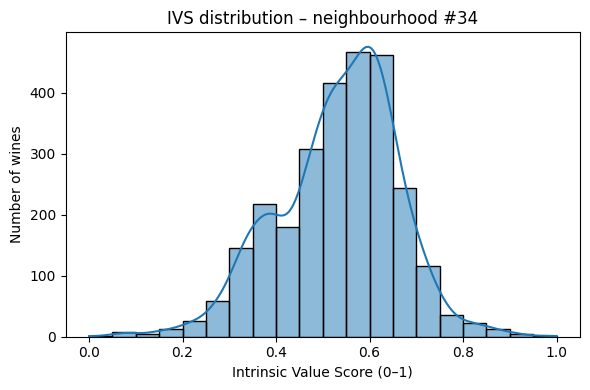

In [21]:
# ----------------------------------------------------------
#  Pick the cluster you want to inspect
# ----------------------------------------------------------
# OPTION A ─ choose by numeric id you saw in the print-out
cluster_to_plot = 34              # <-- replace with your id

# OPTION B ─ choose by (partial) region name
# target_region = "Graves"
# cluster_to_plot = df.loc[df['region'].str.contains(target_region, case=False),
#                          'cluster_id'].mode().iat[0]

sub = df[df['cluster_id'] == cluster_to_plot].copy()

# Short sanity check
print(f"\n>>> Cluster {cluster_to_plot} contains "
      f"{sub['region'].nunique()} region labels / {len(sub)} wines\n")
print("Regions:", ", ".join(sorted(sub['region'].unique())[:10]), end="")
if sub['region'].nunique() > 10:
    print("…")

# ----------------------------------------------------------
#  Distribution plot (choose one style)
# ----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(sub['IVS'], bins=20, kde=True)         # histogram + KDE
# sns.boxplot(x=sub['IVS'], linewidth=1)             # or a simple boxplot
plt.title(f"IVS distribution – neighbourhood #{cluster_to_plot}")
plt.xlabel("Intrinsic Value Score (0–1)")
plt.ylabel("Number of wines")
plt.tight_layout()
plt.show()


Cluster 34 – 2739 wines total
  Good-vintage wines: 1114
  Bad-vintage wines : 464

GOOD vintages – IVS summary:
count    1114.000
mean        0.567
std         0.111
min         0.070
25%         0.508
50%         0.579
75%         0.633
max         0.920
Name: IVS, dtype: float64 

BAD vintages – IVS summary:
count    464.000
mean       0.575
std        0.110
min        0.202
25%        0.511
50%        0.591
75%        0.643
max        0.928
Name: IVS, dtype: float64 



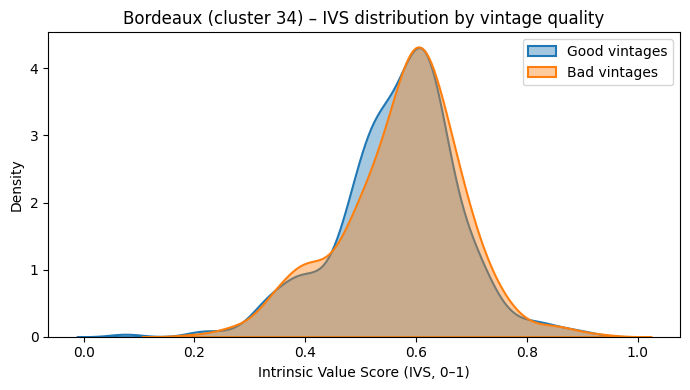

In [24]:
# -------------------------------------------------------------
#  CONFIGURATION – adjust if you prefer different year lists
# -------------------------------------------------------------
GOOD_VINTAGES = ['2015', '2016', '2018', '2019', '2020']   # great years
BAD_VINTAGES  = ['2013', '2017', '2021']               # weak years
CLUSTER_ID    = 34                               # “Bordeaux” cluster

# -------------------------------------------------------------
#  1. Filter the Bordeaux neighbourhood
# -------------------------------------------------------------
bxdx   = df[df['cluster_id'] == CLUSTER_ID].copy()
good   = bxdx[bxdx['vintage'].isin(GOOD_VINTAGES)]
bad    = bxdx[bxdx['vintage'].isin(BAD_VINTAGES)]

print(f"Cluster {CLUSTER_ID} – {len(bxdx)} wines total")
print(f"  Good-vintage wines: {len(good)}")
print(f"  Bad-vintage wines : {len(bad)}\n")

# -------------------------------------------------------------
#  2. Quick descriptive stats
# -------------------------------------------------------------
for label, subset in [('GOOD', good), ('BAD', bad)]:
    print(f"{label} vintages – IVS summary:")
    print(subset['IVS'].describe().round(3), "\n")

# -------------------------------------------------------------
#  3. Distribution plot
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.kdeplot(good['IVS'], label='Good vintages',
            fill=True, alpha=0.4, linewidth=1.5)
sns.kdeplot(bad['IVS'],  label='Bad vintages ',
            fill=True, alpha=0.4, linewidth=1.5)
plt.title("Bordeaux (cluster 34) – IVS distribution by vintage quality")
plt.xlabel("Intrinsic Value Score (IVS, 0–1)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



[Bordeaux cluster 34] vintage-rating rows:
  Good vintages: 1114
  Bad  vintages: 464

GOOD vintages – vintage_rating stats
count    1114.00
mean        3.99
std         0.25
min         3.00
25%         3.80
50%         4.00
75%         4.10
max         4.70
Name: vintage_rating, dtype: float64 

BAD vintages – vintage_rating stats
count    464.00
mean       3.95
std        0.24
min        3.10
25%        3.80
50%        4.00
75%        4.10
max        4.70
Name: vintage_rating, dtype: float64 



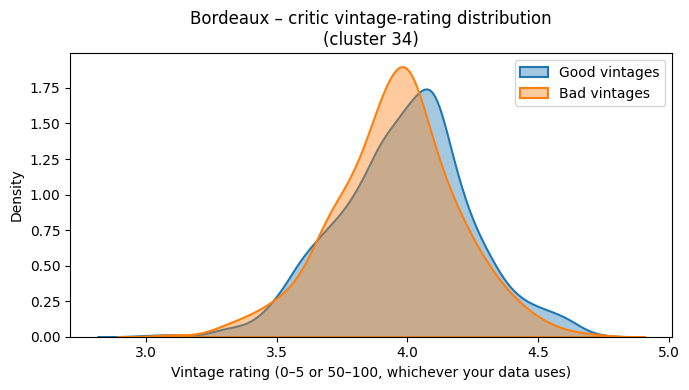

In [25]:
# ------------------------------------------------------------------
# 0.  Safety: make sure the column exists and is numeric
# ------------------------------------------------------------------
if 'vintage_rating' not in df.columns:
    raise KeyError("Column 'vintage_rating' not found in df!")
df['vintage_rating'] = pd.to_numeric(df['vintage_rating'], errors='coerce')

# ------------------------------------------------------------------
# 1.  Re-use the Bordeaux cluster & vintage splits from before
# ------------------------------------------------------------------
bxdx = df[df['cluster_id'] == CLUSTER_ID]
good = bxdx[bxdx['vintage'].isin(GOOD_VINTAGES) & bxdx['vintage_rating'].notna()]
bad  = bxdx[bxdx['vintage'].isin(BAD_VINTAGES)  & bxdx['vintage_rating'].notna()]

print(f"\n[Bordeaux cluster {CLUSTER_ID}] vintage-rating rows:")
print(f"  Good vintages: {len(good)}")
print(f"  Bad  vintages: {len(bad)}\n")

# ------------------------------------------------------------------
# 2.  Quick descriptive stats
# ------------------------------------------------------------------
for label, sub in [('GOOD', good), ('BAD', bad)]:
    print(f"{label} vintages – vintage_rating stats")
    print(sub['vintage_rating'].describe().round(2), "\n")

# ------------------------------------------------------------------
# 3.  KDE plot (rating distribution)
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.kdeplot(good['vintage_rating'], label='Good vintages',
            fill=True, alpha=0.4, linewidth=1.5)
sns.kdeplot(bad['vintage_rating'],  label='Bad vintages',
            fill=True, alpha=0.4, linewidth=1.5)
plt.xlabel("Vintage rating (0–5 or 50–100, whichever your data uses)")
plt.ylabel("Density")
plt.title("Bordeaux – critic vintage-rating distribution\n"
          f"(cluster {CLUSTER_ID})")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from itertools import product
from scipy.stats import norm

# ---------- 0.  basic prep ----------
df['is_good'] = df['vintage'].isin(['2015','2016','2018','2019','2020']).astype(int)   # label

# Wilson lower-bound helper
def wilson(p, n, z=1.96):
    return (p + z**2/(2*n) -
            z*np.sqrt(p*(1-p)/n + z**2/(4*n**2))) / (1 + z**2/n)

df['wilson_LB'] = wilson(df['wine_rating']/5, df['wine_rating_count'])

# ---------- 1.  build each metric ----------
scores = pd.DataFrame(index=df.index)

# RAW + QPR
scores['RAW'] = df['wine_rating']
scores['QPR'] = df['wine_rating'] / np.log1p(df['price'])

# WILSON-γ grid
for g in np.linspace(0,2,5):
    scores[f'WILSON_g{g:.1f}'] = df['wilson_LB'] / (1+np.log1p(df['price']))**g

# BAYES-αβγ grid
alphas  = np.linspace(0.5, 4.0, 8)     # let rating weight vary
betas   = np.linspace(0.0, 2.0, 5)     # NEW: expose count exponent
gammas  = np.linspace(0.0, 2.5, 6)     # explore stronger/slighter price penalties
for a,b,g in product(alphas, betas, gammas):
    name = f'BAYES_a{a:.1f}b{b:.1f}g{g:.1f}'
    scores[name] = (df['wine_rating']**a *
                    np.log1p(df['wine_rating_count'])**b) / \
                   (1+np.log1p(df['price']))**g

# LOGIT-PROB (train/test for fairness)
X = df[['wine_rating','wine_rating_count','price']]
y = df['is_good']
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=.3,random_state=0,stratify=y)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=200).fit(Xtr,ytr)
prob = lr.predict_proba(X)[:,1]
scores['LOGIT_PROB'] = prob          # probability on *all* rows

# ---------- 2.  evaluate separability ----------
def auc(s): return roc_auc_score(df['is_good'], s)
def cohend(s):
    g = s[df['is_good']==1]; b = s[df['is_good']==0]
    return (g.mean()-b.mean()) / np.sqrt((g.var()+b.var())/2)

results = pd.DataFrame({
    'AUC' : scores.apply(auc),
    "Cohen_d": scores.apply(cohend)
}).sort_values('AUC', ascending=False)

print(results.head(10))


C:\Users\boban\AppData\Local\Temp\ipykernel_39588\1309492040.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scores[name] = (df['wine_rating']**a *
C:\Users\boban\AppData\Local\Temp\ipykernel_39588\1309492040.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scores[name] = (df['wine_rating']**a *
C:\Users\boban\AppData\Local\Temp\ipykernel_39588\1309492040.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

                         AUC   Cohen_d
LOGIT_PROB          0.557117  0.239640
BAYES_a1.5b0.0g0.5  0.517724  0.068889
BAYES_a3.0b0.0g1.0  0.517724  0.063804
BAYES_a2.5b0.0g1.0  0.516432  0.059867
BAYES_a2.0b0.0g0.5  0.514123  0.062841
BAYES_a3.0b0.0g1.5  0.513579  0.044477
BAYES_a1.0b0.0g0.5  0.513579  0.061143
BAYES_a2.0b0.0g1.0  0.513579  0.052756
BAYES_a2.5b0.0g1.5  0.511446  0.037645
BAYES_a1.5b0.0g1.0  0.510406  0.043993


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ──────────────────────────────────────────────────────────────────────────────
# 0 .  Make sure the GOOD / BAD vintage label is correct
# ──────────────────────────────────────────────────────────────────────────────
df['vintage'] = pd.to_numeric(df['vintage'], errors='coerce')   # coerce strings -> NaN
GOOD_VINTAGES = ['2015', '2016', '2018', '2019', '2020']                  # adjust if needed
df['is_good'] = df['vintage'].isin(GOOD_VINTAGES).astype(int)

print("Label balance (full data):")
print(df['is_good'].value_counts(), "\n")

# ──────────────────────────────────────────────────────────────────────────────
# 1 .  Define feature matrix X and target y
# ──────────────────────────────────────────────────────────────────────────────
X = df[['wine_rating', 'wine_rating_count', 'price']]           # basic features
y = df['is_good']

# ──────────────────────────────────────────────────────────────────────────────
# 2 .  Stratified train/test split  ← this is STEP 2
# ──────────────────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y          # guarantees same class ratio in both folds
)

print("Label balance (training fold):")
print(y_train.value_counts(), "\n")

# ──────────────────────────────────────────────────────────────────────────────
# 3 .  Guard-railed logistic regression  ← this is STEP 3
# ──────────────────────────────────────────────────────────────────────────────
scores = pd.DataFrame(index=df.index)   # where we’ll store the probability column

if y_train.nunique() < 2:
    # This branch rarely triggers but prevents the classic “one-class” crash
    print("⚠️  Not enough class diversity in training set – logistic model skipped.")
    scores['LOGIT_PROB'] = np.nan
else:
    lr = LogisticRegression(max_iter=200)          # you can add class_weight='balanced' if needed
    lr.fit(X_train, y_train)

    # Probability that each wine comes from a GOOD vintage (0 – 1)
    scores['LOGIT_PROB'] = lr.predict_proba(X)[:, 1]

    # Quick sanity check on separability
    test_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
    print(f"Test ROC-AUC: {test_auc:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
# 4 .  scores now contains 'LOGIT_PROB'; you can merge or compare with other metrics
# ──────────────────────────────────────────────────────────────────────────────


Label balance (full data):
is_good
0    12061
Name: count, dtype: int64 

Label balance (training fold):
is_good
0    8442
Name: count, dtype: int64 

⚠️  Not enough class diversity in training set – logistic model skipped.


In [38]:
# ------------- peek at the vintages for cluster 34 (or full df) -------------
vc = (df[['vintage']]
        .dropna()
        .astype(int)
        .value_counts()
        )
print("Vintages present & sample counts:\n", vc.head(50))   # show first 30 years

Vintages present & sample counts:
 vintage
2022       2062
2021       1644
2020       1464
2019       1028
2023        962
2018        871
2017        602
2016        502
2015        363
2014        332
2013        224
2024        192
2012        190
2011        153
2010        135
2006        108
2009        106
2008        100
2005         80
2001         74
2007         72
2000         61
2003         61
2004         53
1999         50
1998         49
2002         47
1996         38
1995         37
1990         30
1989         30
1997         27
1988         21
1986         18
1993         18
1985         17
1982         17
1994         16
1991         14
1978         12
1983         11
1979          9
1992          9
1975          8
1981          8
1987          7
1966          6
1984          5
1970          5
1974          5
Name: count, dtype: int64


In [42]:
dfw10 = pd.read_parquet('data/weather_cleaned_2010.parquet')
dfw11 = pd.read_parquet('data/weather_cleaned_2011.parquet')
dfw12 = pd.read_parquet('data/weather_cleaned_2012.parquet')    
dfw13 = pd.read_parquet('data/weather_cleaned_2013.parquet')
dfw14 = pd.read_parquet('data/weather_cleaned_2014.parquet')
dfw15 = pd.read_parquet('data/weather_cleaned_2015.parquet')
dfw16 = pd.read_parquet('data/weather_cleaned_2016.parquet')
dfw17 = pd.read_parquet('data/weather_cleaned_2017.parquet')
dfw18 = pd.read_parquet('data/weather_cleaned_2018.parquet')
dfw19 = pd.read_parquet('data/weather_cleaned_2019.parquet')
dfw20 = pd.read_parquet('data/weather_cleaned_2020.parquet')
dfw21 = pd.read_parquet('data/weather_cleaned_2021.parquet')
dfw22 = pd.read_parquet('data/weather_cleaned_2022.parquet')
dfw23 = pd.read_parquet('data/weather_cleaned_2023.parquet')
# Combine all years into a single DataFrame
dfw = pd.concat([dfw10, dfw11, dfw12, dfw13, dfw14, dfw15,
                 dfw16, dfw17, dfw18, dfw19, dfw20, dfw21,
                 dfw22, dfw23], ignore_index=True)

In [43]:
dfw.head()

,dept,station,year,latitude,longitude,altitude,GDD,TM_summer,TX_summer,temp_amp_summer,hot_days,rainy_days_summer,rain_June,rain_SepOct,frost_days_Apr,avg_TM_Apr
0,02,02037002,2010,49.595667,3.610333,78,1088.1,18.846774,24.970968,11.737097,1,7,50.8,101.8,2,10.000000
1,02,02094001,2010,49.009667,3.462667,222,1008.1,18.046774,23.758065,10.790323,0,7,22.9,105.2,0,10.090000
2,02,02110002,2010,49.351333,3.527000,61,1093.2,18.853226,24.967742,11.811290,1,7,34.9,86.2,3,10.113333
3,02,02173002,2010,49.633833,3.197833,83,1077.2,18.650000,24.388710,10.937097,1,8,66.8,90.8,1,9.910000
4,02,02320001,2010,49.818333,3.206000,98,1018.9,18.217742,23.904839,10.998387,0,5,50.7,97.4,0,9.700000


In [45]:
#print the number of stations per year
print("Number of stations per year:")
print(dfw.groupby('year')['station'].nunique())

Number of stations per year:
year
2010    484
2011    503
2012    491
2013    497
2014    476
2015    469
2016    488
2017    485
2018    478
2019    529
2020    571
2021    579
2022    615
2023    622
Name: station, dtype: int64


In [2]:
import polars as pl

# Load original and corrected CSVs
original = pl.read_csv("../../../data/Wine/regions.csv")
corrected = pl.read_csv("../../../data/Wine/regions_corrected.csv")

# Rename columns to avoid collision before join
original = original.rename({"latitude": "latitude_old", "longitude": "longitude_old"})
corrected = corrected.rename({"latitude": "latitude_new", "longitude": "longitude_new"})

# Join on 'region'
comparison = original.join(corrected, on="region", how="inner")

# Add a 'changed' column
comparison = comparison.with_columns([
    ((pl.col("latitude_old") != pl.col("latitude_new")) |
     (pl.col("longitude_old") != pl.col("longitude_new"))).alias("changed")
])

# Filter rows where coordinates changed
differences = comparison.filter(pl.col("changed") == True)

# Save to CSV
differences.write_csv("coordinate_differences.csv")

# Show preview
print(differences.select([
    "region", "latitude_old", "longitude_old", "latitude_new", "longitude_new"
]).head(100))


shape: (10, 5)
┌─────────────────────────────┬──────────────┬───────────────┬──────────────┬───────────────┐
│ region                      ┆ latitude_old ┆ longitude_old ┆ latitude_new ┆ longitude_new │
│ ---                         ┆ ---          ┆ ---           ┆ ---          ┆ ---           │
│ str                         ┆ f64          ┆ f64           ┆ f64          ┆ f64           │
╞═════════════════════════════╪══════════════╪═══════════════╪══════════════╪═══════════════╡
│ bordeaux                    ┆ 44.83779     ┆ -0.57918      ┆ 44.8378      ┆ -0.5792       │
│ graves                      ┆ 44.6         ┆ -0.4          ┆ 44.6         ┆ -0.45         │
│ cotes-catalanes             ┆ 42.625       ┆ 2.5           ┆ 42.7         ┆ 2.8           │
│ blaye-cotes-de-bordeaux     ┆ 45.13333     ┆ -0.66667      ┆ 45.13        ┆ -0.67         │
│ bordeaux-superieur          ┆ 44.83333     ┆ -0.56667      ┆ 44.8378      ┆ -0.5792       │
│ vin-de-pay-s                ┆ 43.61194     